### 

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import dask
import statsmodels.formula.api as sm



In [90]:
from tqdm.notebook import trange, tqdm
from time import sleep

pip install ipywidgets \
jupyter nbextension enable --py widgetsnbextension \
pip install tqdm 

# Data Preprocessing

In [232]:
#DATA_PATH = '/Users/mac/Desktop/Repos/FBD_Project/datasets/'
DATA_PATH = '/Users/zakarysouid/Downloads/'

orderbook_list = sorted(glob.glob(DATA_PATH + 'btcusdt/orderbook/*.csv.gz'))
quote_list = sorted(glob.glob(DATA_PATH + 'btcusdt/quotes/*.csv.gz'))
trade_list = sorted(glob.glob(DATA_PATH + 'btcusdt/trades/*.csv.gz'))

In [266]:
def discretize(
    df_feature: pd.DataFrame,
    numSpreads: int = 4,
    numImbalance: int = 4,
    numdM: int = 2,):
    df_signal = df_feature.copy(deep=True)
    #df_signal['ba_spread']=df_signal['ba_spread'].where(df_signal['side']>=0.1,0.1)
    tick_size = df_signal.ba_spread[df_signal.ba_spread != 0].min()
    # discretize bidask spread then get next time's bidask spread
    # discretize imbalance and get next imbalance
    df_signal = df_signal[df_signal.ba_spread <= numSpreads * tick_size]
    df_signal["ba_spread"] = np.round(df_signal["ba_spread"].div(tick_size)).astype(int)
    df_signal["imbalance"] = pd.cut(
        df_feature["imbalance"],
        bins=np.arange(numImbalance+1) / numImbalance,
        labels=np.arange(1, numImbalance+1),
        include_lowest=True
    )
    return df_signal

def signal(df : pd.DataFrame):
    df['signal'] = np.where(df['g_star'] > 0, 1, -1)
    #df['sum_signal'] = np.where(df['cum_g_star'] > 1, 1, -1)
    return df

# output a boolean if the 'mid_price_change' is greater than 0
def mid_price_change(df : pd.DataFrame):
    df['mid_price_change'] = np.where(df['mid_price'].diff() == 0, 0, 1)
    return df

def number_price_change(df : pd.DataFrame):
    df['number_price_change'] = df['mid_price_change'].cumsum()
    return df

def bid_ask_rebuild(df : pd.DataFrame):
    df['bid_price'] = df['mid_price'] - df['ba_spread']*0.05
    df['ask_price'] = df['mid_price'] + df['ba_spread']*0.05
    return df

def smth_is_happening(df : pd.DataFrame) :
    #df2=pd.DataFrame()
    #df2['smth_is_happening'] = np.where(df['cum_g_star']>= (df['ba_spread']*0.05))
    df2=df.copy(deep=True)
    df2=df2.loc[df2['cum_g_star']>= (df['ba_spread']*0.05)]
    return df2

def ratio(df : pd.DataFrame):
    df['ratio'] = df['g_star']/(df['ba_spread']*0.05)
    return df

def ratio_sum(df : pd.DataFrame):
    df['ratio_sum'] = abs(df['cum_g_star'])/(df['ba_spread']*0.05)
    return df

def time_since_price_change(df : pd.DataFrame):
    df['time_since_price_change'] = df.groupby('number_price_change').cumcount()
    return df

def imbalance(df : pd.DataFrame, horizon : int = 10,memory : bool = False):
    df['bid_amount']= df['amount'].where(df['side']==1,0)
    df['volume']=df['amount'].rolling(min_periods=1, window=horizon).sum()
    df['imbalance']=df['bid_amount'].rolling(min_periods=1,window=horizon).sum()/df['volume']
    df['imbalance_centered'] = df['imbalance'] - 0.5
    df.drop(['bid_amount','signed_amount','volume'], axis=1, inplace=True)
    return df

def imbalance_book(df : pd.DataFrame):
    df['imbalance']=df['ask_amount']/(df['bid_amount']+df['ask_amount'])
    return df

def ba_spread_book(df : pd.DataFrame):
    df['ba_spread']=df['ask_price'] - df['bid_price']
    return df

def mid_price_book(df : pd.DataFrame):
    df['mid_price']=(df['bid_price']+df['ask_price'])/2
    return df

def s_profit(df : pd.DataFrame):
    df['s_profit'] = (df['next_ask_price']- df['bid_price']).where(df['side']==1,df['next_bid_price'] - df['ask_price'])
    return df

In [108]:
df_trades_or = pd.concat((pd.read_csv(f) for f in trade_list[:1]))
df_trades = df_trades_or.copy()
df_trades['timestamp'] = pd.to_datetime(df_trades['timestamp'] / 1000, unit='ms')
df_trades.drop(['id', 'exchange','local_timestamp'], axis=1, inplace=True)
df_trades.replace({'side': {'buy': 1, 'sell': -1}}, inplace=True)

df_trades['bid_price']=df_trades['price'].where(df_trades['side']==1, np.nan)
df_trades['ask_price']=df_trades['price'].where(df_trades['side']==-1, df_trades['bid_price']-0.1)
df_trades['bid_price'].fillna(df_trades['ask_price']+0.1, inplace=True)
df_trades['mid_price']=(df_trades['bid_price']+df_trades['ask_price'])/2


df_trades = mid_price_change(df_trades)
df_trades['next_bid_price']=df_trades['price'].where( (df_trades['side']==1) & (df_trades['mid_price_change']==1), np.nan)
df_trades['next_bid_price'].fillna(method='bfill', inplace=True)
df_trades['next_bid_price'].fillna(method='ffill', inplace=True) #get rid of nan at the end

df_trades['next_ask_price']=df_trades['price'].where((df_trades['side']==-1) & (df_trades['mid_price_change']==1), np.nan)
df_trades['next_ask_price'].fillna(method='bfill', inplace=True)
df_trades['next_ask_price'].fillna(method='ffill', inplace=True) #get rid of nan at the end


df_trades['ba_spread']=0.1

df_trades = s_profit(df_trades)


In [109]:
#rolling imbalances
#df_trades = mid_price_change(df_trades)
df_trades = number_price_change(df_trades)
df_trades = time_since_price_change(df_trades)

df_trades['signed_amount'] = df_trades['amount'] * df_trades['side']
#df_trades['cum_size']= df_trades.groupby('number_price_change')['signed_amount'].cumsum()
df_trades = imbalance(df_trades, horizon=10, memory=True)
df_trades.drop(index=df_trades.index[:50], axis=0, inplace=True)
df_trades.drop(['number_price_change','time_since_price_change','mid_price_change','symbol'],axis=1, inplace=True)

In [110]:
df_trades['imbalance'].where(df_trades['imbalance']>0,0.1,inplace=True)
df_trades['imbalance'].where(df_trades['imbalance']<1,1,inplace=True)



In [267]:
quote_btc = sorted(glob.glob(DATA_PATH + 'btcusdt/quotes/*.csv.gz'))
quote_eth = sorted(glob.glob(DATA_PATH + 'ethusdt/quotes/*.csv.gz'))
quote_ada = sorted(glob.glob(DATA_PATH + 'adausdt/quotes/*.csv.gz'))

In [316]:
df_quote_btc = pd.concat((pd.read_csv(f) for f in quote_btc[6:7]))
df_quote_btc['timestamp'] = pd.to_datetime(df_quote_btc['timestamp'] / 1000, unit='ms')
df_quote_btc = ba_spread_book(df_quote_btc)
df_quote_btc = imbalance_book(df_quote_btc)
df_quote_btc = mid_price_book(df_quote_btc)
df_quote_btc.set_index('timestamp', inplace=True)
df_quote_btc = df_quote_btc.resample('1S').mean()
df_quote_btc['date']=pd.to_datetime(df_quote_btc['local_timestamp'] /1000, unit='ms')
df_quote_btc['date']=df_quote_btc['date'].dt.date
df_quote_btc.drop(['local_timestamp','ask_amount','bid_amount'], axis=1, inplace=True)
df_quote_btc = discretize (df_quote_btc)
df_quote_btc

,ask_price,bid_price,ba_spread,imbalance,mid_price,date
timestamp,,,,,,
2022-09-08 00:00:00,19287.100000,19287.000000,1,1,19287.050000,2022-09-08
2022-09-08 00:00:01,19287.100000,19287.000000,1,1,19287.050000,2022-09-08
2022-09-08 00:00:02,19287.100000,19287.000000,1,1,19287.050000,2022-09-08
2022-09-08 00:00:03,19287.740000,19287.520000,2,1,19287.630000,2022-09-08
2022-09-08 00:00:04,19292.663158,19292.368421,3,1,19292.515789,2022-09-08
...,...,...,...,...,...,...
2022-09-08 23:59:55,19309.400000,19309.300000,1,3,19309.350000,2022-09-08
2022-09-08 23:59:56,19309.400000,19309.300000,1,3,19309.350000,2022-09-08
2022-09-08 23:59:57,19309.400000,19309.300000,1,3,19309.350000,2022-09-08


In [269]:
df_quote_eth = pd.concat((pd.read_csv(f) for f in quote_eth[:1]))
df_quote_eth['timestamp'] = pd.to_datetime(df_quote_eth['timestamp'] / 1000, unit='ms')
df_quote_eth['date'] = df_quote_eth['timestamp'].dt.date
df_quote_eth = ba_spread_book(df_quote_eth)
df_quote_eth = imbalance_book(df_quote_eth)
df_quote_eth = mid_price_book(df_quote_eth)
df_quote_eth.set_index('timestamp', inplace=True)
df_quote_eth = df_quote_eth.resample('1S').mean()
df_quote_eth['date']=pd.to_datetime(df_quote_eth['local_timestamp'] /1000, unit='ms')
df_quote_eth['date']=df_quote_eth['date'].dt.date
df_quote_eth.drop(['local_timestamp','ask_amount','bid_amount'], axis=1, inplace=True)
df_quote_eth = discretize (df_quote_eth)
df_quote_eth

,local_timestamp,ask_amount,ask_price,bid_price,bid_amount,ba_spread,imbalance,mid_price
timestamp,,,,,,,,
2022-09-02 00:00:00,1.662077e+15,84.294667,1585.390000,1585.380000,0.004000,0.010000,0.999952,1585.385000
2022-09-02 00:00:01,1.662077e+15,93.007000,1585.390000,1585.380000,0.004000,0.010000,0.999957,1585.385000
2022-09-02 00:00:02,1.662077e+15,97.269000,1585.390000,1585.380000,0.004000,0.010000,0.999959,1585.385000
2022-09-02 00:00:03,1.662077e+15,21.574111,1585.343333,1585.325556,7.471704,0.017778,0.668268,1585.334444
2022-09-02 00:00:04,1.662077e+15,48.144929,1585.260000,1585.250000,6.481429,0.010000,0.863855,1585.255000
...,...,...,...,...,...,...,...,...
2022-09-02 23:59:55,1.662163e+15,37.227190,1574.376667,1574.366667,13.738381,0.010000,0.441022,1574.371667
2022-09-02 23:59:56,1.662163e+15,15.953810,1574.406667,1574.388571,18.047905,0.018095,0.441552,1574.397619
2022-09-02 23:59:57,1.662163e+15,42.943909,1574.540000,1574.530000,3.650045,0.010000,0.834533,1574.535000


In [ ]:
df_quote_ada = pd.concat((pd.read_csv(f) for f in quote_ada[:1]))
df_quote_ada['timestamp'] = pd.to_datetime(df_quote_ada['timestamp'] / 1000, unit='ms')
df_quote_ada['date'] = df_quote_ada['timestamp'].dt.date
df_quote_ada = ba_spread_book(df_quote_ada)
df_quote_ada = imbalance_book(df_quote_ada)
df_quote_ada = mid_price_book(df_quote_ada)
df_quote_ada.set_index('timestamp', inplace=True)
df_quote_ada = df_quote_eth.resample('1S').mean()
df_quote_ada['date']=pd.to_datetime(df_quote_ada['local_timestamp'] /1000, unit='ms')
df_quote_ada['date']=df_quote_ada['date'].dt.date
df_quote_ada.drop(['local_timestamp','ask_amount','bid_amount'], axis=1, inplace=True)
df_quote_ada = discretize (df_quote_ada)
df_quote_ada

In [281]:
micro_btc = sorted(glob.glob(DATA_PATH + 'btcusdt/microprice/*.csv'))
micro_eth = sorted(glob.glob(DATA_PATH + 'ethusdt/microprice/*.csv'))
micro_ada = sorted(glob.glob(DATA_PATH + 'adausdt/microprice/*.csv'))
print(len(micro_btc), len(micro_eth), len(micro_ada))

114 0 0


In [330]:
import re

# File name containing a date in the format "YYYY-MM-DD"
df_micro_btc = pd.DataFrame()
for filename in micro_btc:
    df=pd.read_csv(filename)
    # Extract the date using a regular expression pattern
    date = re.search(r'\d{4}-\d{2}-\d{2}', filename).group()
    df['date'] = date
    df_micro_btc = df_micro_btc.append(df, ignore_index=True)

df_micro_btc

,ba_spread,imbalance,g_star,date
0,1,1,-0.016683,2022-09-07
1,1,2,-0.004311,2022-09-07
2,1,3,0.004311,2022-09-07
3,1,4,0.016683,2022-09-07
4,2,1,-0.054286,2022-09-07
...,...,...,...,...
1819,3,4,0.075003,2022-12-29
1820,4,1,-0.066668,2022-12-29
1821,4,2,-0.000001,2022-12-29
1822,4,3,0.000001,2022-12-29


In [ ]:
df_micro_eth = pd.DataFrame()
for filename in micro_eth:
    df=pd.read_csv(filename)
    # Extract the date using a regular expression pattern
    date = re.search(r'\d{4}-\d{2}-\d{2}', filename).group()
    df['date'] = date
    df_micro_eth = df_micro_eth.append(df, ignore_index=True)

In [ ]:
df_micro_ada = pd.DataFrame()
for filename in micro_ada:
    df=pd.read_csv(filename)
    # Extract the date using a regular expression pattern
    date = re.search(r'\d{4}-\d{2}-\d{2}', filename).group()
    df['date'] = date
    df_micro_ada = df_micro_ada.append(df, ignore_index=True)

In [333]:
df_quote_btc_dis = pd.merge(
            df_quote_btc.reset_index(),
            df_micro_btc,
            how='left',
            on=['date','ba_spread','imbalance'], 
        ).set_index('timestamp')

In [334]:
df_quote_btc_dis

,ask_price,bid_price,ba_spread,imbalance,mid_price,date,g_star
timestamp,,,,,,,
2022-09-08 00:00:00,19287.100000,19287.000000,1,1,19287.050000,2022-09-08,NaN
2022-09-08 00:00:01,19287.100000,19287.000000,1,1,19287.050000,2022-09-08,NaN
2022-09-08 00:00:02,19287.100000,19287.000000,1,1,19287.050000,2022-09-08,NaN
2022-09-08 00:00:03,19287.740000,19287.520000,2,1,19287.630000,2022-09-08,NaN
2022-09-08 00:00:04,19292.663158,19292.368421,3,1,19292.515789,2022-09-08,NaN
...,...,...,...,...,...,...,...
2022-09-08 23:59:55,19309.400000,19309.300000,1,3,19309.350000,2022-09-08,NaN
2022-09-08 23:59:56,19309.400000,19309.300000,1,3,19309.350000,2022-09-08,NaN
2022-09-08 23:59:57,19309.400000,19309.300000,1,3,19309.350000,2022-09-08,NaN


In [21]:
# micro price calculation: mid_price + g_star
df_dis_g['micro_price'] = df_dis_g['mid_price'] + df_dis_g['g_star'] 
df_dis_quotes_g['micro_price'] = df_dis_quotes_g['mid_price'] + df_dis_quotes_g['g_star']


,index_x,side,price,amount,bid_price,ask_price,mid_price,next_bid_price,next_ask_price,ba_spread,s_profit,imbalance,imbalance_centered,index_y,g_star,micro_price
timestamp,,,,,,,,,,,,,,,,
2022-09-02 00:00:03.600000000,50,1,20122.6,0.014,20122.6,20122.5,20122.55,20121.4,20122.4,1,-0.2,4,0.479740,3,0.016683,20122.566683
2022-09-02 00:00:03.604000000,51,1,20122.6,0.008,20122.6,20122.5,20122.55,20121.4,20122.4,1,-0.2,4,0.436073,3,0.016683,20122.566683
2022-09-02 00:00:03.604999936,52,-1,20122.5,0.001,20122.6,20122.5,20122.55,20121.4,20122.4,1,-1.1,4,0.355769,3,0.016683,20122.566683
2022-09-02 00:00:03.604999936,53,1,20122.6,0.001,20122.6,20122.5,20122.55,20121.4,20122.4,1,-0.2,4,0.342105,3,0.016683,20122.566683
2022-09-02 00:00:03.614000128,54,1,20122.6,0.001,20122.6,20122.5,20122.55,20121.4,20122.4,1,-0.2,4,0.335165,3,0.016683,20122.566683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-02 23:59:59.724999936,3954193,1,19941.1,0.007,19941.1,19941.0,19941.05,19941.1,19940.2,1,-0.9,4,0.500000,3,0.016683,19941.066683
2022-09-02 23:59:59.726000128,3954194,1,19941.1,0.050,19941.1,19941.0,19941.05,19941.1,19940.2,1,-0.9,4,0.500000,3,0.016683,19941.066683
2022-09-02 23:59:59.734000128,3954195,1,19941.1,0.001,19941.1,19941.0,19941.05,19941.1,19940.2,1,-0.9,4,0.500000,3,0.016683,19941.066683


In [22]:
df_signal = signal(df_dis_g)
df_signal = mid_price_change(df_signal)
#df_signal = bid_ask_rebuild(df_signal)
df_signal = number_price_change(df_signal)
df_signal = time_since_price_change(df_signal)
df_signal = ratio(df_signal)



#delete useless columns
#add sum_g_star to df_signal until mid_price_change = 1
df_signal['weighted_g_star'] = df_signal['g_star'] * (df_signal['time_since_price_change']+1/df_signal['time_since_price_change'].mean())
df_signal['cum_g_star'] = df_signal.groupby('number_price_change').cumsum()['weighted_g_star'] 
df_signal = ratio_sum(df_signal)
df_signal = df_signal.drop(['index_x','index_y','signal','number_price_change','mid_price_change'], axis=1)
#df_test = smth_is_happening(df_signal)
#df_test
df_signal

,side,price,amount,bid_price,ask_price,mid_price,next_bid_price,next_ask_price,ba_spread,s_profit,imbalance,imbalance_centered,g_star,micro_price,time_since_price_change,ratio,weighted_g_star,cum_g_star,ratio_sum
timestamp,,,,,,,,,,,,,,,,,,,
2022-09-02 00:00:03.600000000,1,20122.6,0.014,20122.6,20122.5,20122.55,20121.4,20122.4,1,-0.2,4,0.479740,0.016683,20122.566683,0,0.333654,0.000600,0.000600,0.011997
2022-09-02 00:00:03.604000000,1,20122.6,0.008,20122.6,20122.5,20122.55,20121.4,20122.4,1,-0.2,4,0.436073,0.016683,20122.566683,1,0.333654,0.017283,0.017882,0.357647
2022-09-02 00:00:03.604999936,-1,20122.5,0.001,20122.6,20122.5,20122.55,20121.4,20122.4,1,-1.1,4,0.355769,0.016683,20122.566683,2,0.333654,0.033965,0.051848,1.036951
2022-09-02 00:00:03.604999936,1,20122.6,0.001,20122.6,20122.5,20122.55,20121.4,20122.4,1,-0.2,4,0.342105,0.016683,20122.566683,3,0.333654,0.050648,0.102495,2.049909
2022-09-02 00:00:03.614000128,1,20122.6,0.001,20122.6,20122.5,20122.55,20121.4,20122.4,1,-0.2,4,0.335165,0.016683,20122.566683,4,0.333654,0.067331,0.169826,3.396520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-02 23:59:59.724999936,1,19941.1,0.007,19941.1,19941.0,19941.05,19941.1,19940.2,1,-0.9,4,0.500000,0.016683,19941.066683,94,0.333654,1.568771,22.706409,454.128188
2022-09-02 23:59:59.726000128,1,19941.1,0.050,19941.1,19941.0,19941.05,19941.1,19940.2,1,-0.9,4,0.500000,0.016683,19941.066683,95,0.333654,1.585454,24.291863,485.837269
2022-09-02 23:59:59.734000128,1,19941.1,0.001,19941.1,19941.0,19941.05,19941.1,19940.2,1,-0.9,4,0.500000,0.016683,19941.066683,96,0.333654,1.602137,25.894000,517.880003


In [23]:
df_signal_light = df_signal[['s_profit','g_star','ratio','weighted_g_star','cum_g_star','ratio_sum']]
abs(df_signal_light['s_profit']).cumsum()


timestamp
2022-09-02 00:00:03.600000000    2.000000e-01
2022-09-02 00:00:03.604000000    4.000000e-01
2022-09-02 00:00:03.604999936    1.500000e+00
2022-09-02 00:00:03.604999936    1.700000e+00
2022-09-02 00:00:03.614000128    1.900000e+00
                                     ...     
2022-09-02 23:59:59.724999936    5.232690e+06
2022-09-02 23:59:59.726000128    5.232690e+06
2022-09-02 23:59:59.734000128    5.232691e+06
2022-09-02 23:59:59.736999936    5.232691e+06
2022-09-02 23:59:59.840000000    5.232692e+06
Name: s_profit, Length: 3954148, dtype: float64

In [27]:
result_ratio = sm.ols(formula="s_profit ~ ratio ", data=df_signal_light).fit()
result_g_star = sm.ols(formula="s_profit ~ g_star ", data=df_signal_light).fit()
result_weighted_g_star = sm.ols(formula="s_profit ~ weighted_g_star ", data=df_signal_light).fit()
result_cum_g_star = sm.ols(formula="s_profit ~ cum_g_star ", data=df_signal_light).fit()
result_ratio_sum = sm.ols(formula="s_profit ~ ratio_sum ", data=df_signal_light).fit()
result_imbalance = sm.ols(formula="s_profit ~ imbalance ", data=df_trades).fit()
result_imbalance_centered = sm.ols(formula="s_profit ~ imbalance_centered ", data=df_trades).fit()

print(result_ratio.summary())

                            OLS Regression Results                            
Dep. Variable:               s_profit   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                 9.098e+04
Date:                Thu, 02 Feb 2023   Prob (F-statistic):               0.00
Time:                        22:22:06   Log-Likelihood:            -9.7465e+06
No. Observations:             3954148   AIC:                         1.949e+07
Df Residuals:                 3954146   BIC:                         1.949e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0200      0.001     13.995      0.0

In [ ]:
print(result_g_star.summary())

                            OLS Regression Results                            
Dep. Variable:               s_profit   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                 9.098e+04
Date:                Sun, 29 Jan 2023   Prob (F-statistic):               0.00
Time:                        13:23:36   Log-Likelihood:            -9.7465e+06
No. Observations:             3954148   AIC:                         1.949e+07
Df Residuals:                 3954146   BIC:                         1.949e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0200      0.001     13.995      0.0

In [172]:
print(result_weighted_g_star.summary())

                            OLS Regression Results                            
Dep. Variable:               s_profit   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                 1.538e+04
Date:                Sun, 29 Jan 2023   Prob (F-statistic):               0.00
Time:                        13:23:47   Log-Likelihood:            -9.7838e+06
No. Observations:             3954148   AIC:                         1.957e+07
Df Residuals:                 3954146   BIC:                         1.957e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0180      0.001     

In [173]:
print(result_cum_g_star.summary())

                            OLS Regression Results                            
Dep. Variable:               s_profit   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     53.52
Date:                Sun, 29 Jan 2023   Prob (F-statistic):           2.56e-13
Time:                        13:23:52   Log-Likelihood:            -9.7914e+06
No. Observations:             3954148   AIC:                         1.958e+07
Df Residuals:                 3954146   BIC:                         1.958e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0185      0.001     12.753      0.0

In [174]:
print(result_ratio_sum.summary())

                            OLS Regression Results                            
Dep. Variable:               s_profit   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     385.6
Date:                Sun, 29 Jan 2023   Prob (F-statistic):           7.50e-86
Time:                        13:23:57   Log-Likelihood:            -9.7913e+06
No. Observations:             3954148   AIC:                         1.958e+07
Df Residuals:                 3954146   BIC:                         1.958e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0205      0.001     14.102      0.0

In [37]:
print(result_imbalance.summary())

                            OLS Regression Results                            
Dep. Variable:               s_profit   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                 9.591e+04
Date:                Sun, 29 Jan 2023   Prob (F-statistic):               0.00
Time:                        21:01:38   Log-Likelihood:            -9.7441e+06
No. Observations:             3954148   AIC:                         1.949e+07
Df Residuals:                 3954146   BIC:                         1.949e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4892      0.002   -224.877      0.0

In [42]:
print(result_imbalance_centered.summary())

                            OLS Regression Results                            
Dep. Variable:               s_profit   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                 9.617e+04
Date:                Sun, 29 Jan 2023   Prob (F-statistic):               0.00
Time:                        21:02:48   Log-Likelihood:            -9.7439e+06
No. Observations:             3954148   AIC:                         1.949e+07
Df Residuals:                 3954146   BIC:                         1.949e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0202    

In [18]:
df_mvt = df_signal.copy(deep=True)
df_mvt = df_mvt.loc[df_mvt['time_since_price_change']==0]
df_signal['ask_change']=-df_signal['ask_price'].diff(-1)
df_signal['bid_change']=-df_signal['bid_price'].diff(-1)
df_signal['ask_next_change']=df_signal['ask_change'].replace(0,method='bfill')
df_signal['bid_next_change']=df_signal['bid_change'].replace(0,method='bfill')
df_signal_light = df_signal.drop(['index_x','index_y','signal','number_price_change','mid_price','ba_spread','micro_price','bid_price','ask_price','mid_price_change'], axis=1)

df_signal_light.corr()

,imbalance,g_star,time_since_price_change,ratio,weighted_g_star,cum_g_star,ratio_sum,ask_change,bid_change,ask_next_change,bid_next_change
imbalance,1.000000,0.983937,0.011950,0.997336,0.494438,0.139164,0.017748,0.226754,0.222004,0.248945,0.246648
g_star,0.983937,1.000000,0.011895,0.991576,0.483818,0.135557,0.018023,0.240529,0.240573,0.252865,0.252908
time_since_price_change,0.011950,0.011895,1.000000,0.012054,0.066219,0.162801,0.705664,0.000979,0.000807,0.005354,0.005900
ratio,0.997336,0.991576,0.012054,1.000000,0.492165,0.138017,0.018334,0.241841,0.241911,0.255584,0.255657
weighted_g_star,0.494438,0.483818,0.066219,0.492165,1.000000,0.497980,0.109688,0.054827,0.054866,0.099320,0.099325
cum_g_star,0.139164,0.135557,0.162801,0.138017,0.497980,1.000000,0.404153,0.008587,0.008609,0.022192,0.022244
ratio_sum,0.017748,0.018023,0.705664,0.018334,0.109688,0.404153,1.000000,0.000256,0.000447,-0.001303,-0.001128
ask_change,0.226754,0.240529,0.000979,0.241841,0.054827,0.008587,0.000256,1.000000,0.986681,0.645918,0.645899
bid_change,0.222004,0.240573,0.000807,0.241911,0.054866,0.008609,0.000447,0.986681,1.000000,0.637313,0.653838
ask_next_change,0.248945,0.252865,0.005354,0.255584,0.099320,0.022192,-0.001303,0.645918,0.637313,1.000000,0.993836


In [13]:
df_mvt['ask_change']=-df_mvt['ask_price'].diff(-1)
df_mvt['bid_change']=-df_mvt['bid_price'].diff(-1)
df_mvt_light = df_mvt.drop(['index_x','index_y','signal','number_price_change','mid_price','ba_spread','micro_price','bid_price','ask_price','mid_price_change', 'time_since_price_change'], axis=1)



df_mvt_light.corr()

,imbalance,g_star,ratio,weighted_g_star,cum_g_star,ratio_sum,ask_change,bid_change
imbalance,1.000000,0.959446,0.995365,0.959446,0.959446,-0.002767,0.275173,0.269304
g_star,0.959446,1.000000,0.977610,1.000000,1.000000,-0.001697,0.283395,0.283337
ratio,0.995365,0.977610,1.000000,0.977610,0.977610,-0.002152,0.292730,0.292711
weighted_g_star,0.959446,1.000000,0.977610,1.000000,1.000000,-0.001697,0.283395,0.283337
cum_g_star,0.959446,1.000000,0.977610,1.000000,1.000000,-0.001697,0.283395,0.283337
ratio_sum,-0.002767,-0.001697,-0.002152,-0.001697,-0.001697,1.000000,0.000566,0.000771
ask_change,0.275173,0.283395,0.292730,0.283395,0.283395,0.000566,1.000000,0.986682
bid_change,0.269304,0.283337,0.292711,0.283337,0.283337,0.000771,0.986682,1.000000


# Trading algorithm

In [69]:
df_trading_bot = df_dis_g.copy(deep=True)
df_trading_bot.drop(['index_x','index_y','next_bid_price','next_ask_price','signal','mid_price_change','number_price_change','time_since_price_change','weighted_g_star','cum_g_star','ratio_sum','s_profit',],axis=1,inplace=True)
max_pos=0.10
df_trading_bot['g_star_change']= np.sign(df_trading_bot['g_star']).diff()
df_trading_bot['g_star_change'].fillna(0, inplace=True)

In [117]:
df_trading_bot_quotes = df_dis_quotes_g.copy(deep=True)
df_trading_bot_quotes['g_star_change']= np.sign(df_trading_bot_quotes['g_star']).diff()
df_trading_bot_quotes['g_star_change'].fillna(0, inplace=True)

In [70]:
# df_trading_bot['money']=0
# df_trading_bot['buy_position']=0
# df_trading_bot['buy_position_money']=0
# df_trading_bot['buy_position_invested']=0

# df_trading_bot['sell_position']=0
# df_trading_bot['sell_position']=0
# df_trading_bot['sell_position_money']=0
# df_trading_bot['profit']=0
# df_trading_bot['cum_profit']=0
# df_trading_bot['money']=100000
# df_trading_bot.head()


# #access previous row data


In [71]:
df_trading_bot.head()

,side,price,amount,bid_price,ask_price,mid_price,ba_spread,imbalance,imbalance_centered,g_star,micro_price,ratio,g_star_change
timestamp,,,,,,,,,,,,,
2022-09-02 00:00:03.600000000,1,20122.6,0.014,20122.6,20122.5,20122.55,1,4,0.479740,0.016683,20122.566683,0.333654,0.0
2022-09-02 00:00:03.604000000,1,20122.6,0.008,20122.6,20122.5,20122.55,1,4,0.436073,0.016683,20122.566683,0.333654,0.0
2022-09-02 00:00:03.604999936,-1,20122.5,0.001,20122.6,20122.5,20122.55,1,4,0.355769,0.016683,20122.566683,0.333654,0.0
2022-09-02 00:00:03.604999936,1,20122.6,0.001,20122.6,20122.5,20122.55,1,4,0.342105,0.016683,20122.566683,0.333654,0.0
2022-09-02 00:00:03.614000128,1,20122.6,0.001,20122.6,20122.5,20122.55,1,4,0.335165,0.016683,20122.566683,0.333654,0.0


In [72]:
# #trading logic
# """if g_star > 0 and money > 0:
# place bid order at bid_price, add amount to position, substract money by bid_price * position
# if g_star < 0 and position > 0 and bid_price < ask_price: 
# sell position at ask_price, substract position, add money by ask_price * position
# profit = position * (aks_price - bid_price))
     
# if g_star < 0 and money > 0:
# place sell order at ask_price, add position
# if g_star > 0 and position > 0 and bid_price < ask_price:
# buy position at bid_price, substract position, add money by bid_price * position
    
# """

# #conditions to open a buy trade : g_star > 0 and money > 0
# df_trading_bot['buy_position'] = np.where((df_trading_bot['g_star'] > 0) & (df_trading_bot['money'] > 0), max_pos*df_trading_bot['money']/df_trading_bot['bid_price'], 0)
# df_trading_bot['buy_position_money'] = np.where((df_trading_bot['buy_position'] > 0),max_pos*df_trading_bot['money'], 0)
# df_trading_bot['buy_position_invested'] = df_trading_bot['buy_position_money'].cumsum()

# # conditions to close a buy trade : position > 0 and g_star_change < 0


In [146]:
df_sig = pd.read_csv('df_sig.csv')
df_sig = bid_ask_rebuild(df_sig)
df_sig['g_star_change']= np.sign(df_sig['g_star']).diff()
df_sig['g_star_change'].fillna(0, inplace=True)
df_sig

,timestamp,mid_price,ba_spread,imbalance,g_star,micro_price,bid_price,ask_price,g_star_change
0,2022-09-02 00:00:00,20122.55,1,1,-0.016683,20122.533317,20122.5,20122.6,0.0
1,2022-09-02 00:00:01,20122.55,1,1,-0.016683,20122.533317,20122.5,20122.6,0.0
2,2022-09-02 00:00:03,20120.75,1,1,-0.016683,20120.733317,20120.7,20120.8,0.0
3,2022-09-02 00:00:08,20124.85,1,4,0.016683,20124.866683,20124.8,20124.9,2.0
4,2022-09-02 00:00:09,20124.85,1,3,0.004311,20124.854311,20124.8,20124.9,0.0
...,...,...,...,...,...,...,...,...,...
318696,2022-09-06 23:59:48,18779.95,1,1,-0.016683,18779.933317,18779.9,18780.0,0.0
318697,2022-09-06 23:59:49,18779.95,1,1,-0.016683,18779.933317,18779.9,18780.0,0.0
318698,2022-09-06 23:59:51,18780.55,1,4,0.016683,18780.566683,18780.5,18780.6,2.0
318699,2022-09-06 23:59:54,18784.35,1,3,0.004311,18784.354311,18784.3,18784.4,0.0


In [150]:
class trade :
    def __init__(self, side, price, amount):
        self.side = side
        self.price = price
        self.amount = amount
        self.invested = price*amount
        self.realized = 0
        self.profit = 0
        
    def close(self, ask_price, bid_price) : 
        if self.side == 'buy' :
            self.realized=ask_price*self.amount
            self.profit = self.realized - self.invested
        else : 
            #self.profit=(self.price-bid_price)*self.amount
            self.realized=bid_price*self.amount
            self.profit = self.invested - self.realized
            self.realized=self.invested+self.profit
        
        
    # def __str__(self):
    #     return self.side + " " + str(self.price) + " " + str(self.amount) + " " + str(self.profit)
    # def __repr__(self):
    #     return self.side + " " + str(self.price) + " " + str(self.amount)  + " " + str(self.profit)
    
            
class portfolio : 
    def __init__(self, size, max_pos):
        self.size = size
        self.trades = []
        self.profit = []
        self.returns = []
        self.g_star = 0 
        self.ask_price = 0
        self.bid_price = 0
        self.g_star_change = 0
        self.time = 0
        self.max_pos = max_pos*self.size
        self.to_invest = size
 
    def choose_trade(self):
        if self.g_star_change != 0:
            self.close_all()
        elif self.to_invest > 0 :
            if self.g_star>0 : self.open_trade('buy', self.bid_price, self.max_pos/self.bid_price)
            if self.g_star<0 : self.open_trade('sell', self.ask_price, self.max_pos/self.ask_price)
        
    def open_trade(self, side, price, amount):
        self.trades.append(trade(side, price, amount))
        self.to_invest -= self.trades[-1].invested
        
    def close_trades(self, trade):
        trade.close(self.bid_price, self.ask_price)
        self.to_invest += trade.realized
        #self.profit += trade.profit
        
    def close_all(self):
        for trade in self.trades:
            self.close_trades(trade)
            self.profit.append(trade.profit)
            
        self.trades.clear()

    
    def update(self, df):
        self.g_star = df['g_star']
        self.ask_price = df['ask_price']
        self.bid_price = df['bid_price']
        self.g_star_change = df['g_star_change']
        self.choose_trade()
    


In [170]:
df_trading_bot.iloc[0]['g_star']
portfolio1=portfolio(200, 1)
for i in range(0, int(len(df_trading_bot)/5)):
    portfolio1.update(df_trading_bot.iloc[i])
portfolio1.close_all()

In [120]:
portfolio2=portfolio(200, 0.1)
for i in range(0, int(len(df_trading_bot_quotes)/10)):
    portfolio2.update(df_trading_bot_quotes.iloc[i])
portfolio2.close_all()

In [186]:
portfolio3=portfolio(200, 1)
for i in range(0, int(len(df_sig)/5)):
    portfolio3.update(df_sig.iloc[i])
portfolio3.close_all()

In [188]:
results1 = pd.DataFrame(portfolio1.profit, columns=['profit'])
results1['cumsum'] = results1['profit'].cumsum()
results1['profit'].sum()

235.34309951614725

In [187]:
results3 = pd.DataFrame(portfolio3.profit, columns=['profit'])
results3['cumsum'] = results3['profit'].cumsum()
results3['profit'].sum()

181.93764211875495

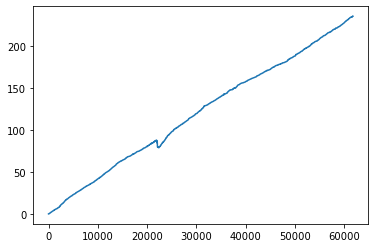

In [180]:
plt.plot(results1['cumsum'])